# Checking model for errors

## Is the channel distribution what I think it is?
**Plot channel distribution vs function**

### Import cell class

In [2]:
# %load MSN_builder.py
#
"""
'''
The MSN class defining the cell
'''

from neuron import h
from math import exp
import json

# Distributions:
'''
T-type Ca: g = 1.0/( 1 +np.exp{(x-70)/-4.5} )
naf (den): (0.1 + 0.9/(1 + np.exp((x-60.0)/10.0)))

'''

def calculate_distribution(d3, dist, a4, a5,  a6,  a7, g8):
    '''
    Used for setting the maximal conductance of a segment.
    Scales the maximal conductance based on somatic distance and distribution type.

    Parameters:
    d3   = distribution type:
         0 linear, 
         1 sigmoidal, 
         2 exponential
         3 step function
    dist = somatic distance of segment
    a4-7 = distribution parameters 
    g8   = base conductance (similar to maximal conductance)

    '''

    if   d3 == 0: 
        value = a4 + a5*dist
    elif d3 == 1: 
        value = a4 + a5/(1 + exp((dist-a6)/a7) )
    elif d3 == 2: 
        value = a4 + a5*exp((dist-a6)/a7)
    elif d3 == 3:
        if (dist > a6) and (dist < a7):
            value = a4
        else:
            value = a5

    if value < 0:
        value = 0

    value = value*g8
    return value 




# ======================= the MSN class ==================================================

class MSN:
    def __init__(self,  params=None,                                \
                        morphology='latest_WT-P270-20-14ak.swc',    \
                        variables=None,                             \
                        section=None,                               \
                        SF = 1.0                                    ):
        Import = h.Import3d_SWC_read()
        Import.input(morphology)
        imprt = h.Import3d_GUI(Import, 0)
        imprt.instantiate(None)
        h.define_shape()
        # h.cao0_ca_ion = 2  # default in nrn
        h.celsius = 35
        self._create_sectionlists()
        self._set_nsegs(section=section)
        self.v_init = -80
        for sec in self.allseclist:
            sec.Ra = 150
            sec.cm = 1.0
            sec.insert('pas')
            #sec.g_pas = 1e-5 # set using json file
            sec.e_pas = -70 # -73
        for sec in self.somalist:
            sec.insert('naf')
            sec.insert('kaf')
            sec.insert('kas')
            sec.insert('kdr')
            sec.insert('kir')
            sec.ena = 50
            sec.ek = -85 # -90
            sec.insert('cal12')
            sec.insert('cal13')
            sec.insert('car')
            sec.insert('cadyn')
            sec.insert('caldyn')
            sec.insert('sk')
            sec.insert('bk')
            sec.insert('can')
        for sec in self.axonlist:
            sec.insert('naf')
            sec.insert('kas')
            sec.ena = 50
            sec.ek = -85 # -90
        for sec in self.dendlist:
            sec.insert('naf')
            sec.insert('kaf')
            sec.insert('kas')
            sec.insert('kdr')
            sec.insert('kir')
            sec.ena = 50
            sec.ek = -85 # -90
            sec.insert('cal12')
            sec.insert('cal13')
            sec.insert('car')
            sec.insert('cadyn')
            sec.insert('caldyn')
            sec.insert('sk')
            sec.insert('bk')
            sec.insert('cat32')
            sec.insert('cat33')

        with open(params) as file:
            par = json.load(file)

        self.distribute_channels("soma", "g_pas", 0, 1, 0, 0, 0, float(par['g_pas_all']['Value']))
        self.distribute_channels("axon", "g_pas", 0, 1, 0, 0, 0, float(par['g_pas_all']['Value']))
        self.distribute_channels("dend", "g_pas", 0, 1, 0, 0, 0, float(par['g_pas_all']['Value']))

        self.distribute_channels("soma", "gbar_naf", 0, 1, 0, 0, 0, SF*float(par['gbar_naf_somatic']['Value']))
        self.distribute_channels("soma", "gbar_kaf", 0, 1, 0, 0, 0, SF*float(par['gbar_kaf_somatic']['Value']))
        self.distribute_channels("soma", "gbar_kas", 0, 1, 0, 0, 0, SF*float(par['gbar_kas_somatic']['Value']))
        self.distribute_channels("soma", "gbar_kdr", 0, 1, 0, 0, 0, SF*float(par['gbar_kdr_somatic']['Value']))
        self.distribute_channels("soma", "gbar_kir", 0, 1, 0, 0, 0, SF*float(par['gbar_kir_somatic']['Value']))
        self.distribute_channels("soma", "gbar_sk",  0, 1, 0, 0, 0, SF*float(par['gbar_sk_somatic']['Value']))
        self.distribute_channels("soma", "gbar_bk",  0, 1, 0, 0, 0, SF*float(par['gbar_bk_somatic']['Value']))

        self.distribute_channels("axon", "gbar_naf", 3, 1, 1.1, 30, 500, float(par['gbar_naf_axonal']['Value']))
        self.distribute_channels("axon", "gbar_kas", 0, 1, 0, 0, 0,      float(par['gbar_kas_axonal']['Value']))

        if variables:
            self.distribute_channels("dend", "gbar_kaf", 1,   1, variables[0],  variables[1],  variables[2], float(par['gbar_kaf_basal']['Value']))
            self.distribute_channels("dend", "gbar_naf", 1, 1.0 - variables[3], variables[3], variables[4], variables[5], float(par['gbar_naf_basal']['Value']))
        else:
            self.distribute_channels("dend", "gbar_naf", 1, 0.1, 0.9,   60.0,   10.0, float(par['gbar_naf_basal']['Value']))
            self.distribute_channels("dend", "gbar_kaf", 1,   1, 0.5,  120.0,  -30.0, float(par['gbar_kaf_basal']['Value']))

        self.distribute_channels("dend", "gbar_kas", 2,   1, 9.0,  0.0, -5.0, float(par['gbar_kas_basal']['Value']))
        self.distribute_channels("dend", "gbar_kdr", 0, 1, 0, 0, 0, float(par['gbar_kdr_basal']['Value']))
        self.distribute_channels("dend", "gbar_kir", 0, 1, 0, 0, 0, float(par['gbar_kir_basal']['Value']))
        self.distribute_channels("dend", "gbar_sk",  0, 1, 0, 0, 0, float(par['gbar_sk_basal']['Value']))
        self.distribute_channels("dend", "gbar_bk",  0, 1, 0, 0, 0, float(par['gbar_bk_basal']['Value']))

        self.distribute_channels("soma", "pbar_cal12", 0, 1, 0, 0, 0, SF*1e-5)
        self.distribute_channels("soma", "pbar_cal13", 0, 1, 0, 0, 0, SF*1e-6)
        self.distribute_channels("soma", "pbar_car",   0, 1, 0, 0, 0, SF*1e-4)
        self.distribute_channels("soma", "pbar_can",   0, 1, 0, 0, 0, SF*3e-5)
        self.distribute_channels("dend", "pbar_cal12", 0, 1, 0, 0, 0, 1e-5)
        self.distribute_channels("dend", "pbar_cal13", 0, 1, 0, 0, 0, 1e-6)
        self.distribute_channels("dend", "pbar_car",   0, 1, 0, 0, 0, 1e-4)
        self.distribute_channels("dend", "pbar_cat32", 1, 0, 1.0, 120.0, -30.0, 1e-7)
        self.distribute_channels("dend", "pbar_cat33", 1, 0, 1.0, 120.0, -30.0, 1e-8)


    def _create_sectionlists(self):
        self.allsecnames = []
        self.allseclist  = h.SectionList()
        for sec in h.allsec():
            self.allsecnames.append(sec.name())
            self.allseclist.append(sec=sec)
        self.nsomasec = 0
        self.somalist = h.SectionList()
        for sec in h.allsec():
            if sec.name().find('soma') >= 0:
                self.somalist.append(sec=sec)
                if self.nsomasec == 0:
                    self.soma = sec
                self.nsomasec += 1
        self.axonlist = h.SectionList()
        for sec in h.allsec():
            if sec.name().find('axon') >= 0:
                self.axonlist.append(sec=sec)
        self.dendlist = h.SectionList()
        for sec in h.allsec():
            if sec.name().find('dend') >= 0:
                self.dendlist.append(sec=sec)


    def _set_nsegs(self, section=None, N=20):
        ''' def seg/sec. if section: set seg ~= 1/um  '''
        if section:
            dend_name = 'dend[' + str(int(section)) + ']'
            for sec in self.allseclist:
                if sec.name() == dend_name:
                    # TODO: this needs some thinking; how to best set number of segments
                    n = 2*int(sec.L/2.0)+1
                    if n > N:
                        sec.nseg = n
                    else:
                        sec.nseg = 2(N/2) + 1 # odd number of seg
                else:
                    sec.nseg = 2*int(sec.L/40.0)+1
        else:
            for sec in self.allseclist:
                sec.nseg = 2*int(sec.L/40.0)+1
        for sec in self.axonlist:
            sec.nseg = 2  # two segments in axon initial segment



    def _max_dist(self, axon_excluding=True):
        '''find maximal dendritic branch length''' 
        h.distance(sec=self.soma)
        dmax = 0
        for sec in self.allseclist:
            if axon_excluding and sec.name().find('axon') == 0: continue
                dmax = max(dmax, h.distance(1, sec=sec))
        return dmax




    def distribute_channels(self, as1, as2, d3, a4, a5, a6, a7, g8):
        h.distance(sec=self.soma)
        dmax = self._max_dist()

        for sec in self.allseclist:

            # if right cellular compartment (axon, soma or dend)
            if sec.name().find(as1) >= 0:
                for seg in sec:
                    dist = h.distance(seg.x, sec=sec)
                    val = calculate_distribution(d3, dist, a4, a5, a6, a7, g8)
                    cmd = 'seg.%s = %g' % (as2, val)
                    exec(cmd)



class Spine():
    '''
    Spine class. Create a spine with a spine with neck and head.
    Based on Mattioni and Le Novere, (2013).
    https://senselab.med.yale.edu/ModelDB/ShowModel.cshtml?model=150284&file=/TimeScales-master/neuronControl/spine.py#tabs-2
    '''

    def __init__(self, sec, id,         \
                       neck_L=1.0,      \
                       neck_dia=0.1,    \
                       head_L=0.5,      \
                       head_dia=0.5,    \
                       Ra=150.0     ):
        ''' Create a spine with geometry given by the arguments'''

        self.id         =   id
        self.neck       =   self.create_neck(neck_L=neck_L, neck_dia=neck_dia, Ra=Ra)
        self.head       =   self.create_head(self.neck, head_L=head_L, head_dia=head_dia)
        self.parent     =   None # the parent section connected to the neck
        #self.synapses   =   self.create_synapses()


    def create_neck(self, neck_L=1.0, neck_dia=0.1, Ra=150.0):
        ''' Create a spine neck '''

        name_sec        =   self.id + "_neck"
        h("create "     +   name_sec)
        neck            =   getattr(h, name_sec)
        neck.nseg       =   1
        neck.L          =   neck_L 
        neck.diam       =   neck_dia
        neck.Ra         =   Ra 
        neck.cm         =   1.0

        for mech in [   'pas',      \
                        'cav32',    \
                        'cav33',    \
                        'cadyn'     ]:
            neck.insert(mech)
        neck.g_pas      =   1.25e-5
        neck.e_pas      =   -70 

        return neck



    def create_head(self, neck, head_L=0.5, head_dia=0.5, Ra=150.0):
        '''Create the head of the spine and populate it with channels'''

        name_sec        =   self.id + "_head"
        h("create "     +   name_sec)
        head            =   getattr(h, name_sec)

        head.nseg       =   1
        head.L          =   head_L
        head.diam       =   head_dia
        head.Ra         =   Ra
        head.cm         =   1.0

        for mech in [   'pas',      \
                        'kir',      \
                        'cav32',    \
                        'cav33',    \
                        'car',      \
                        'cal12',    \
                        'cal13',    \
                        'cadyn',    \
                        'caldyn'    ]:
            head.insert(mech)
        head.g_pas      =   1.25e-5
        head.e_pas      =   -70 

        head.connect(neck)

        return head



    def attach(self, parentSec, parentx, childx):
        '''Attach a spine to a parentSec and store the parentSec into an attribute.
        Just an handy variation of the connect method'''
        self.neck.connect(parentSec, parentx, childx)
        self.parent = parentSec
        self.pos = parentx



"""  



'\n\'\'\'\nThe MSN class defining the cell\n\'\'\'\n\nfrom neuron import h\nfrom math import exp\nimport json\n\n# Distributions:\n\'\'\'\nT-type Ca: g = 1.0/( 1 +np.exp{(x-70)/-4.5} )\nnaf (den): (0.1 + 0.9/(1 + np.exp((x-60.0)/10.0)))\n\n\'\'\'\n\ndef calculate_distribution(d3, dist, a4, a5,  a6,  a7, g8):\n    \'\'\'\n    Used for setting the maximal conductance of a segment.\n    Scales the maximal conductance based on somatic distance and distribution type.\n\n    Parameters:\n    d3   = distribution type:\n         0 linear, \n         1 sigmoidal, \n         2 exponential\n         3 step function\n    dist = somatic distance of segment\n    a4-7 = distribution parameters \n    g8   = base conductance (similar to maximal conductance)\n\n    \'\'\'\n\n    if   d3 == 0: \n        value = a4 + a5*dist\n    elif d3 == 1: \n        value = a4 + a5/(1 + exp((dist-a6)/a7) )\n    elif d3 == 2: \n        value = a4 + a5*exp((dist-a6)/a7)\n    elif d3 == 3:\n        if (dist > a6) and (di

### Setup 

In [3]:
from __future__ import print_function, division
from neuron import h
import numpy                as np
import MSN_builder          as build
import matplotlib.pyplot    as plt

h.load_file('stdlib.hoc')
h.load_file('import3d.hoc')
       
# initiate cell
SF   =   1.3394248833242937
cell =   build.MSN(  params='./params_dMSN.json',                   \
                     morphology='latest_WT-P270-20-14ak.swc',       \
                     SF=SF                                          )
    

h.distance(1, sec=h.soma[0])

def get_chan_cond_new():
    
    RES      = {}
    channels = ['naf', 'kas', 'kaf', 'kir', 'cal12', 'cal13']
    for chan in channels:
        RES[chan] = []
    RES['DIST']=[]
    
    for sec in h.allsec():
        
        if sec.name().find('dend') < 0:
            continue
            
        for seg in sec:
            
            distance = h.distance(seg.x, sec=sec)
            RES['DIST'].append(distance)
            
            area     = seg.area()
            
            for mech in seg:
                
                if mech.name() in channels:
                    m    = channels.index(mech.name())
                    chan = channels[m]
                    
                    if chan[0]=='c':
                        conductance = mech.pbar
                    else:
                        conductance = mech.gbar
                        
                    RES[mech.name()].append(conductance)
    return RES
            



## Plotting distributions of maximal conductance (gbar/pbar)

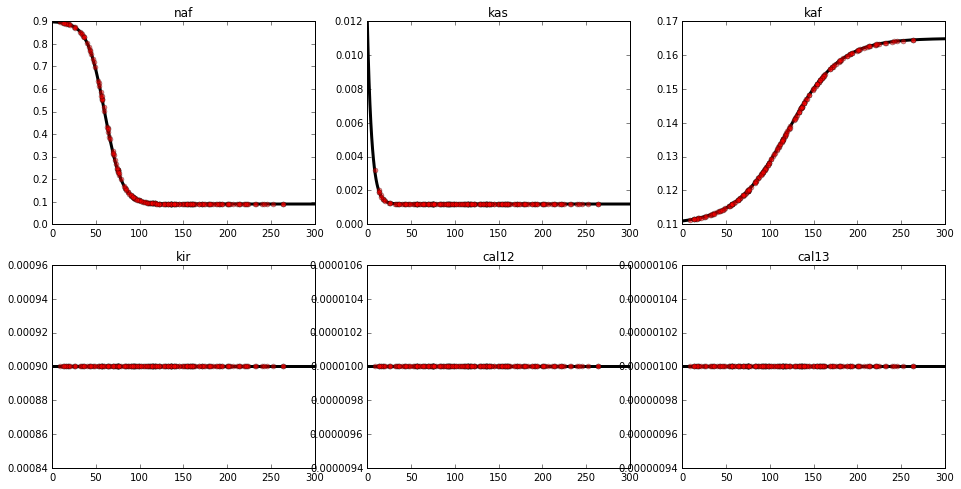

In [4]:
dist  = np.arange(0,300)
vect  = np.ones(len(dist))
naf   = 0.9  * ( 0.1 + 0.9/(1 + np.exp(  (dist-60 )/10 ) ) )
kas   = 0.0012 * (1 + 9 * np.exp(-dist/5) )
kaf   = 0.11 * (   1 + 0.5/(1 + np.exp( -(dist-120)/30 ) ) )
kir   = 9/(10**4) * vect
cal12 = 1/(10**5) * vect
cal13 = 1/(10**6) * vect
can   = 3/(10**5) * vect


#DIST, NAF = get_chan_cond('naf', 'gbar')
RES = get_chan_cond_new()

fig, ax = plt.subplots(2,3, figsize=(16,8))

channels = ['naf', 'kas', 'kaf', 'kir', 'cal12', 'cal13']
chanList = [naf, kas, kaf, kir, cal12, cal13, can ]

for c,chan in enumerate(channels):
    
    i = int(np.floor(c/3))
    j = c%3
    
    ax[i,j].plot(dist, chanList[c], color='k', lw=3)
    ax[i,j].plot(RES['DIST'], RES[chan], 'or', ms=5, alpha=0.5)
    ax[i,j].set_title(chan)



plt.show()

**they seems to be alright (off by 0.5 $\mu$m, due to diff in somatic r)**
## Setup simulation function

In [5]:
#%%writefile model_validation.py       


def calc_rand_Modulation(mod_list, range_list=False):
    '''
    uses numpy to draws random modulation factors in range [0,2],
    from a uniform distribution, for each channel in mod_list.
    
    The factors can also be linearly mapped to an arbitrary interval. 
    This is done if a range_list is given.
    
    mod_list     = list of channels to be modulated
    range_list   = list of [min, max] values to be used in modulation. 
                    Must have same length as mod_list.
    '''
    
    mod_factors = []
    
    A=0
    B=2
    
    for i,channel in enumerate(mod_list):
        
        factor = 2.0 * np.random.uniform()
    
        if range_list:
            
            a       = range_list[i][0]
            b       = range_list[i][1]
            
            factor = (b-a) / (B-A) * (factor-A) + a
       
        mod_factors.append(factor)
        
    return mod_factors

    


def main(par="./params_dMSN.json",                  \
                            amp=0.265,              \
                            run=None,               \
                            simDur=100,            \
                            stimDur=100,            \
                            cell_type='D1',         \
                            mod_fact=None,          \
                            morphology='latest_WT-P270-20-14ak.swc'  ):
    
    
    # initiate cell
    SF   =   1.3394248833242937
    cell = build.MSN(  params=par, \
                       morphology=morphology, \
                       SF=SF )
    
    # record current
    channels = ['naf', 'kas', 'kaf', 'kir', 'kdr', 'sk', 'bk', 'cal12', 'cal13', 'can', 'car', 'cat32', 'cat33']
    rec      = {}
    SEG      = {}
    
    for sec in h.allsec():
        Type = sec.name().split('[')[0]
        if Type in SEG:
            continue
        
        for seg in sec:

            if Type in SEG:
                break
            else:
                SEG[Type] = True

            for mech in seg:

                if mech.name() in channels:

                    # build record vector
                    name = mech.name() + '_' + Type
                    rec[name] = h.Vector()
                    
                    if name[0] == 'n':
                        rec[name].record(mech._ref_ina)
                    elif name[2] in ['l', 't']:
                        rec[name].record(mech._ref_ical)
                    elif name[0] == 'c':
                        rec[name].record(mech._ref_ica)
                    else:
                        rec[name].record(mech._ref_ik)
                        
    
    
    # set cascade--not connected to channels in this script, 
    # but used for setting pointers needed in the channel mechnisms
    casc    =   h.D1_reduced_cascade2_0(0.5, sec=cell.soma) 
    pointer =   casc._ref_Target1p    


    # set edge of soma as reference for dendritic distance 
    h.distance(1, sec=h.soma[0])


    # set current injection
    stim        =   h.IClamp(0.5, sec=cell.soma)
    stim.amp    =   amp  
    stim.delay  =   10
    stim.dur    =   stimDur    


    # record vectors
    tm  = h.Vector()
    tm.record(h._ref_t)
    vm  = h.Vector()
    vm.record(cell.soma(0.5)._ref_v)


    tstop       = simDur 
    # dt = default value; 0.025 ms (25 us)


    # set pointers; need since same mechanisms are used for dynamic modulation of channels.
    # Modulation of channels is not used in this script

    for sec in h.allsec():

        if sec.name().find('spine') >= 0:
            continue

        for seg in sec:

            # naf and kas is in all sections
            h.setpointer(pointer, 'pka', seg.kas )
            h.setpointer(pointer, 'pka', seg.naf )

            if sec.name().find('axon') < 0:    


                # these channels are not in the axon section
                h.setpointer(pointer, 'pka', seg.kaf )
                h.setpointer(pointer, 'pka', seg.cal12 )
                h.setpointer(pointer, 'pka', seg.cal13 )
                h.setpointer(pointer, 'pka', seg.kir )

                if sec.name().find('soma') >= 0:


                    # N-type Ca (can) is only distributed to the soma section
                    h.setpointer(pointer, 'pka', seg.can )
                    
    
    # run simulation
    if mod_fact:
        
        # channels to modulate channels
        mod_list    = ['naf', 'kas', 'kaf', 'kir', 'cal12', 'cal13', 'can' ] 


        for sec in h.allsec():

            # modulate axon?
            if sec.name().find('axon') >= 0:
                if not modulate_axon:
                    continue

            for seg in sec:

                for mech in seg:

                    if mech.name() in mod_list: 

                        # get factor from list
                        factor = mod_fact[mod_list.index(mech.name() )]

                        if mech.name()[0] == 'c':
                            # Ca channels
                            pbar        = mech.pbar
                            mech.pbar   = pbar * factor

                        else:
                            # non Ca channels
                            gbar        = mech.gbar
                            mech.gbar   = gbar * factor
                
        


    # solver------------------------------------------------------------------------------            
    cvode = h.CVode()

    h.finitialize(cell.v_init)

    
    while h.t < tstop:
        h.fadvance()
    
    rec['tm'] = tm
    rec['vm'] = vm
    
    return rec
        
        
    

## Run simulation and plott channel currents
One channel from each cellular compartment (soma, axon, dendrite)

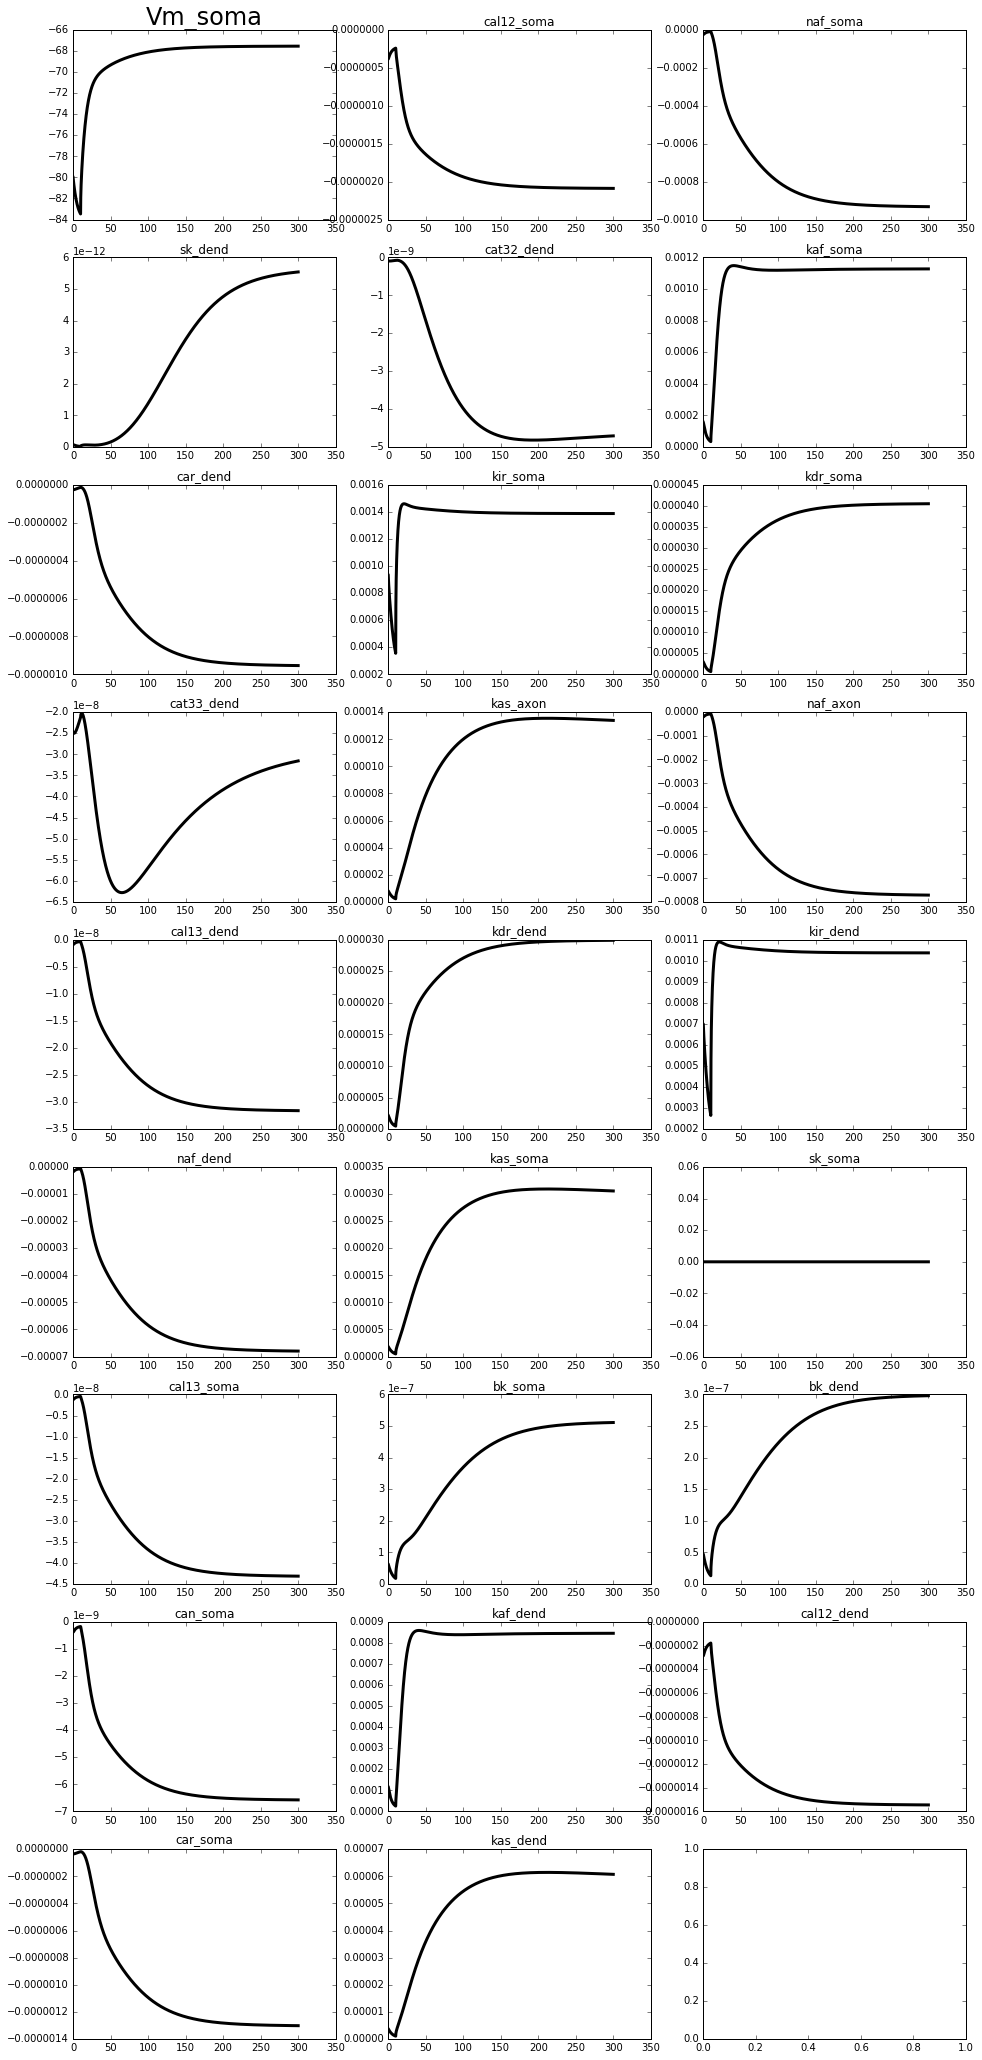

In [16]:
                                          
cell_type   =   'D1'
par         =   './params_dMSN.json'
morphology  =   'latest_WT-P270-20-14ak.swc'



rec =   main(   par=par,            \
        morphology=morphology,      \
        amp=250e-3,                 \
        simDur=300,                 \
        stimDur=300,                \
        cell_type=cell_type  )

N = len(rec)
n = int(N/3)

fig,ax = plt.subplots( n, 3, figsize=(16,n*4) )

tm = rec['tm']
ax[0,0].plot(tm, rec['vm'],    lw=3, color='k')
ax[0,0].set_title('Vm_soma', fontsize=24)

c = 1
for key in rec:
    i = int(np.floor(c/3))
    j = c%3
    
    if key in ['tm', 'vm']:
        continue
    else:
        c += 1
        ax[i,j].plot(tm, rec[key], lw=3, color='k')
        ax[i,j].set_title(key)
        
plt.show()

all channels seems to give current
## Modulation of channels
Static modulation change of maximal conductance (gbar/pbar)
* are channels modulated?
* are modulation factors correctly drawn/set?

['naf', 'kas', 'kaf', 'kir', 'cal12', 'cal13', 'can']
[0.7934183583022661, 0.8338472568498909, 0.7825758954055054, 0.9321837570335099, 1.679835582346606, 1.491927114496332, 0.9234157649089864]


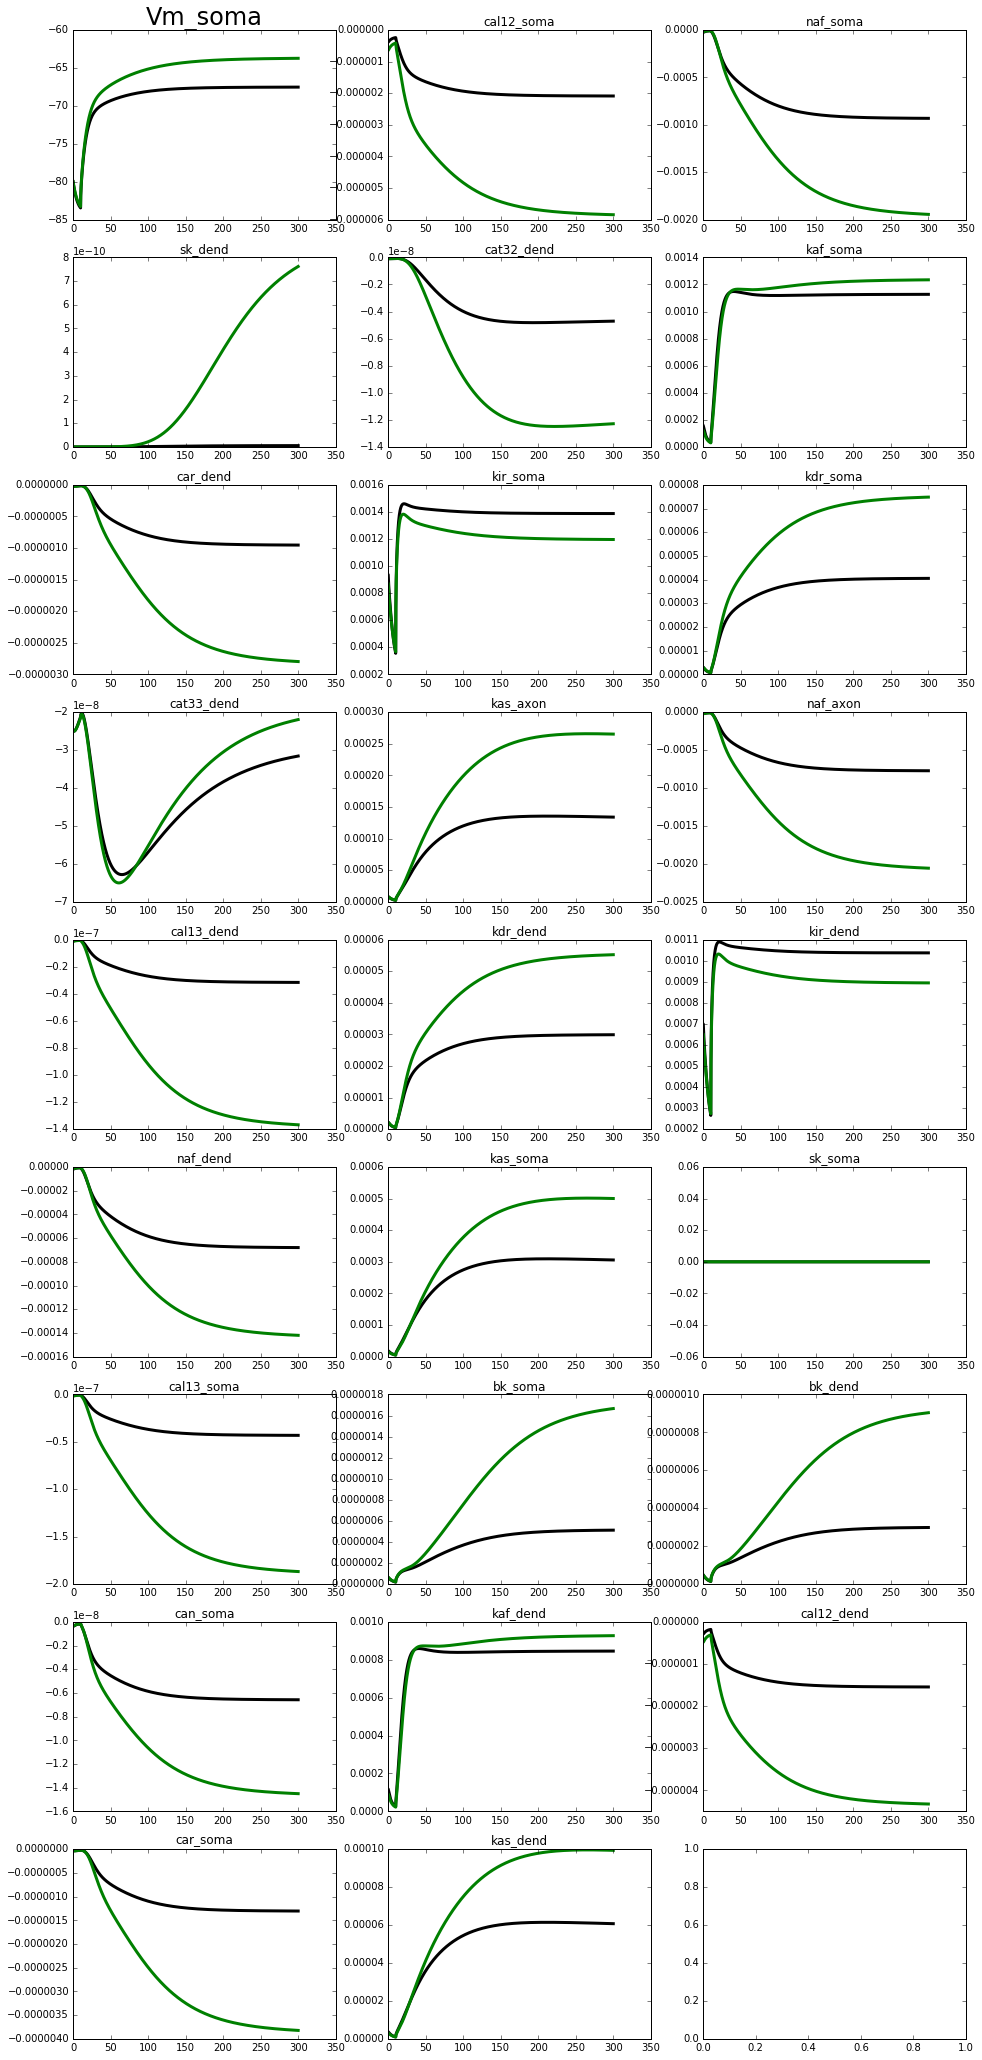

In [15]:

factors = calc_rand_Modulation(['naf', 'kas', 'kaf', 'kir', 'cal12', 'cal13', 'can' ], \
                               range_list=[[0.60,0.80], \
                                              [0.65,0.85],  \
                                              [0.75,0.85],  \
                                              [0.85,1.25],  \
                                              [1.0,2.0],    \
                                              [1.0,2.0],    \
                                              [0.0,1.0]]    )

modRec =    main(   par=par,            \
            morphology=morphology,      \
            amp=250e-3,                 \
            simDur=300,                 \
            stimDur=300,                \
            mod_fact=factors,           \
            cell_type=cell_type  )

print(['naf', 'kas', 'kaf', 'kir', 'cal12', 'cal13', 'can' ])
print(factors)

fig,ax = plt.subplots( n, 3, figsize=(16,n*4) )

tm = rec['tm']
ax[0,0].plot(tm, rec['vm'],    lw=3, color='k')
ax[0,0].plot(tm, modRec['vm'], lw=3, color='g')
ax[0,0].set_title('Vm_soma', fontsize=24)

c = 1
for key in rec:
    i = int(np.floor(c/3))
    j = c%3
    
    if key in ['tm', 'vm']:
        continue
    else:
        c += 1
        ax[i,j].plot(tm, rec[key],    lw=3, color='k')
        ax[i,j].plot(tm, modRec[key], lw=3, color='g')
        ax[i,j].set_title(key)
        
plt.show()

In [17]:

# initiate cell
cell =   build.MSN(  params='./params_dMSN.json',                   \
                     morphology='latest_WT-P270-20-14ak.swc',       \
                     SF=SF                                          )




# channels to modulate channels
mod_list    = ['naf', 'kas', 'kaf', 'kir', 'cal12', 'cal13', 'can' ] 


# use same factors for all three current injections
mod_fact = calc_rand_Modulation(mod_list, 
                               range_list=[[0.60,0.80], \
                                          [0.65,0.85],  \
                                          [0.75,0.85],  \
                                          [0.85,1.25],  \
                                          [1.0,2.0],    \
                                          [1.0,2.0],    \
                                          [0.0,1.0]]    )

print( mod_list )
print( mod_fact )

modulate_axon = False

for sec in h.allsec():

    # modulate axon?
    if sec.name().find('axon') >= 0:
        if not modulate_axon:
            continue
    
    print( sec.name() )
    
    for seg in sec:
        
        print( '\t', seg.x)
        print( '\t\t\t', 'pbar', '\t\t', 'factor', '\t', 'mech.pbar')

        for mech in seg:

            if mech.name() in mod_list: 

                # get factor from list
                factor = mod_fact[mod_list.index(mech.name() )]

                if mech.name()[0] == 'c':
                    # Ca channels
                    pbar        = mech.pbar
                    mech.pbar   = pbar * factor
                    
                    print( '\t\t', mech.name(), pbar, '*', factor, '=', mech.pbar)

                else:
                    # non Ca channels
                    gbar        = mech.gbar
                    mech.gbar   = gbar * factor
                    
                    print( '\t\t', mech.name(), gbar, '*', factor, '=', mech.gbar)
                    
                
                
                

['naf', 'kas', 'kaf', 'kir', 'cal12', 'cal13', 'can']
[0.7551184141575777, 0.8437406120140599, 0.7964935722224276, 1.095510634554741, 1.933458017663293, 1.9774993242519403, 0.052891278132966346]
soma[0]
	 0.5
			 pbar 		 factor 	 mech.pbar
		 can 4.01827e-05 * 0.052891278133 = 2.12531436183e-06
		 cal13 1.33942e-06 * 1.97749932425 = 2.64870214489e-06
		 cal12 1.33942e-05 * 1.93345801766 = 2.58971233802e-05
		 kir 0.00120548 * 1.09551063455 = 0.00132061615974
		 kas 0.0160731 * 0.843740612014 = 0.013561527231
		 kaf 0.147337 * 0.796493572222 = 0.117352973451
		 naf 12.0548 * 0.755118414158 = 9.10280145899
dend[0]
	 0.5
			 pbar 		 factor 	 mech.pbar
		 cal13 1e-06 * 1.97749932425 = 1.97749932425e-06
		 cal12 1e-05 * 1.93345801766 = 1.93345801766e-05
		 kir 0.0009 * 1.09551063455 = 0.000985959571099
		 kas 0.0032333 * 0.843740612014 = 0.00272806652083
		 kaf 0.111299 * 0.796493572222 = 0.0886489380948
		 naf 0.895399 * 0.755118414158 = 0.676132272918
dend[1]
	 0.166666666667
			 pbar 		 

		 kas 0.0012 * 0.843740612014 = 0.00101248873442
		 kaf 0.163757 * 0.796493572222 = 0.130431397906
		 naf 0.09 * 0.755118414158 = 0.0679606572742
	 0.954545454545
			 pbar 		 factor 	 mech.pbar
		 cal13 1e-06 * 1.97749932425 = 1.97749932425e-06
		 cal12 1e-05 * 1.93345801766 = 1.93345801766e-05
		 kir 0.0009 * 1.09551063455 = 0.000985959571099
		 kas 0.0012 * 0.843740612014 = 0.00101248873442
		 kaf 0.164341 * 0.796493572222 = 0.130896550153
		 naf 0.09 * 0.755118414158 = 0.0679606572742
dend[13]
	 0.5
			 pbar 		 factor 	 mech.pbar
		 cal13 1e-06 * 1.97749932425 = 1.97749932425e-06
		 cal12 1e-05 * 1.93345801766 = 1.93345801766e-05
		 kir 0.0009 * 1.09551063455 = 0.000985959571099
		 kas 0.00120012 * 0.843740612014 = 0.00101258998329
		 kaf 0.115984 * 0.796493572222 = 0.0923805104806
		 naf 0.557074 * 0.755118414158 = 0.420656835448
dend[14]
	 0.1
			 pbar 		 factor 	 mech.pbar
		 cal13 1e-06 * 1.97749932425 = 1.97749932425e-06
		 cal12 1e-05 * 1.93345801766 = 1.93345801766e-05
		 ki

			 pbar 		 factor 	 mech.pbar
		 cal13 1e-06 * 1.97749932425 = 1.97749932425e-06
		 cal12 1e-05 * 1.93345801766 = 1.93345801766e-05
		 kir 0.0009 * 1.09551063455 = 0.000985959571099
		 kas 0.0012 * 0.843740612014 = 0.00101248873442
		 kaf 0.143262 * 0.796493572222 = 0.114107262144
		 naf 0.09056 * 0.755118414158 = 0.0683835235861
	 0.3
			 pbar 		 factor 	 mech.pbar
		 cal13 1e-06 * 1.97749932425 = 1.97749932425e-06
		 cal12 1e-05 * 1.93345801766 = 1.93345801766e-05
		 kir 0.0009 * 1.09551063455 = 0.000985959571099
		 kas 0.0012 * 0.843740612014 = 0.00101248873442
		 kaf 0.15135 * 0.796493572222 = 0.120549302156
		 naf 0.0900722 * 0.755118414158 = 0.0680151768237
	 0.5
			 pbar 		 factor 	 mech.pbar
		 cal13 1e-06 * 1.97749932425 = 1.97749932425e-06
		 cal12 1e-05 * 1.93345801766 = 1.93345801766e-05
		 kir 0.0009 * 1.09551063455 = 0.000985959571099
		 kas 0.0012 * 0.843740612014 = 0.00101248873442
		 kaf 0.15714 * 0.796493572222 = 0.125160999939
		 naf 0.0900093 * 0.755118414158 = 0.0

		 kas 0.0012 * 0.843740612014 = 0.00101248873442
		 kaf 0.138542 * 0.796493572222 = 0.110347812483
		 naf 0.0915963 * 0.755118414158 = 0.0691660527987
	 0.5
			 pbar 		 factor 	 mech.pbar
		 cal13 1e-06 * 1.97749932425 = 1.97749932425e-06
		 cal12 1e-05 * 1.93345801766 = 1.93345801766e-05
		 kir 0.0009 * 1.09551063455 = 0.000985959571099
		 kas 0.0012 * 0.843740612014 = 0.00101248873442
		 kaf 0.146972 * 0.796493572222 = 0.117062253297
		 naf 0.0902327 * 0.755118414158 = 0.0681363733292
	 0.833333333333
			 pbar 		 factor 	 mech.pbar
		 cal13 1e-06 * 1.97749932425 = 1.97749932425e-06
		 cal12 1e-05 * 1.93345801766 = 1.93345801766e-05
		 kir 0.0009 * 1.09551063455 = 0.000985959571099
		 kas 0.0012 * 0.843740612014 = 0.00101248873442
		 kaf 0.153773 * 0.796493572222 = 0.122479206081
		 naf 0.0900339 * 0.755118414158 = 0.0679862557884
dend[52]
	 0.166666666667
			 pbar 		 factor 	 mech.pbar
		 cal13 1e-06 * 1.97749932425 = 1.97749932425e-06
		 cal12 1e-05 * 1.93345801766 = 1.93345801766e